In [2]:
!pip install google_play_scraper
!pip install textblob
!pip install seaborn
!pip install Sastrawi
!pip install openpyxl
!pip install nltk
!pip install swifter  # Untuk mempercepat processing dengan apply parallel
!pip install emoji # install emoji library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import emoji
import nltk
import swifter  # Import swifter

# Pastikan resource NLTK sudah diunduh
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True) # Download punkt_tab resource

from google_play_scraper import app, Sort, reviews_all
from textblob import TextBlob
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Import modul untuk Bag of Words dan Klasifikasi
from sklearn.feature_selection import SelectKBest, chi2 # Added for feature selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15,10)

print("Memulai proses scraping data review...")

Memulai proses scraping data review...


In [3]:
# MEMUAT DATA MENTAH DARI FILE JIKA SUDAH ADA
try:
    df_mymrtjrev = pd.read_csv('raw_reviews.csv')
    print("Data mentah berhasil dimuat dari raw_reviews.csv")
except FileNotFoundError:
    print("raw_reviews.csv tidak ditemukan, melakukan scraping ulang...")
    mymrtj_reviews = reviews_all(
        'com.mrt.jakarta',
        sleep_milliseconds=100,  # Ditambahkan delay untuk menghindari blocking
        lang='id',
        sort=Sort.NEWEST,
        count=5000  # Batasi jumlah review
    )
    df_mymrtjrev = pd.DataFrame(mymrtj_reviews)
    df_mymrtjrev.to_csv('raw_reviews.csv', index=False)
    df_mymrtjrev.to_excel('raw_reviews.xlsx', index=False)
    print("Data mentah hasil scraping disimpan ke raw_reviews.csv dan raw_reviews.xlsx")

Data mentah berhasil dimuat dari raw_reviews.csv


In [4]:
# Kolom yang tidak diperlukan untuk analisis sentimen
df_mymrtjrev_filtered = df_mymrtjrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]
print("\nInformasi DataFrame awal:")
df_mymrtjrev_filtered.info()


Informasi DataFrame awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401 entries, 0 to 1400
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   content               1401 non-null   object
 1   score                 1401 non-null   int64 
 2   thumbsUpCount         1401 non-null   int64 
 3   reviewCreatedVersion  1239 non-null   object
 4   at                    1401 non-null   object
 5   replyContent          46 non-null     object
 6   repliedAt             46 non-null     object
dtypes: int64(2), object(5)
memory usage: 76.7+ KB



Distribusi skor review:
score
5    855
1    301
4    116
3     68
2     61
Name: count, dtype: int64


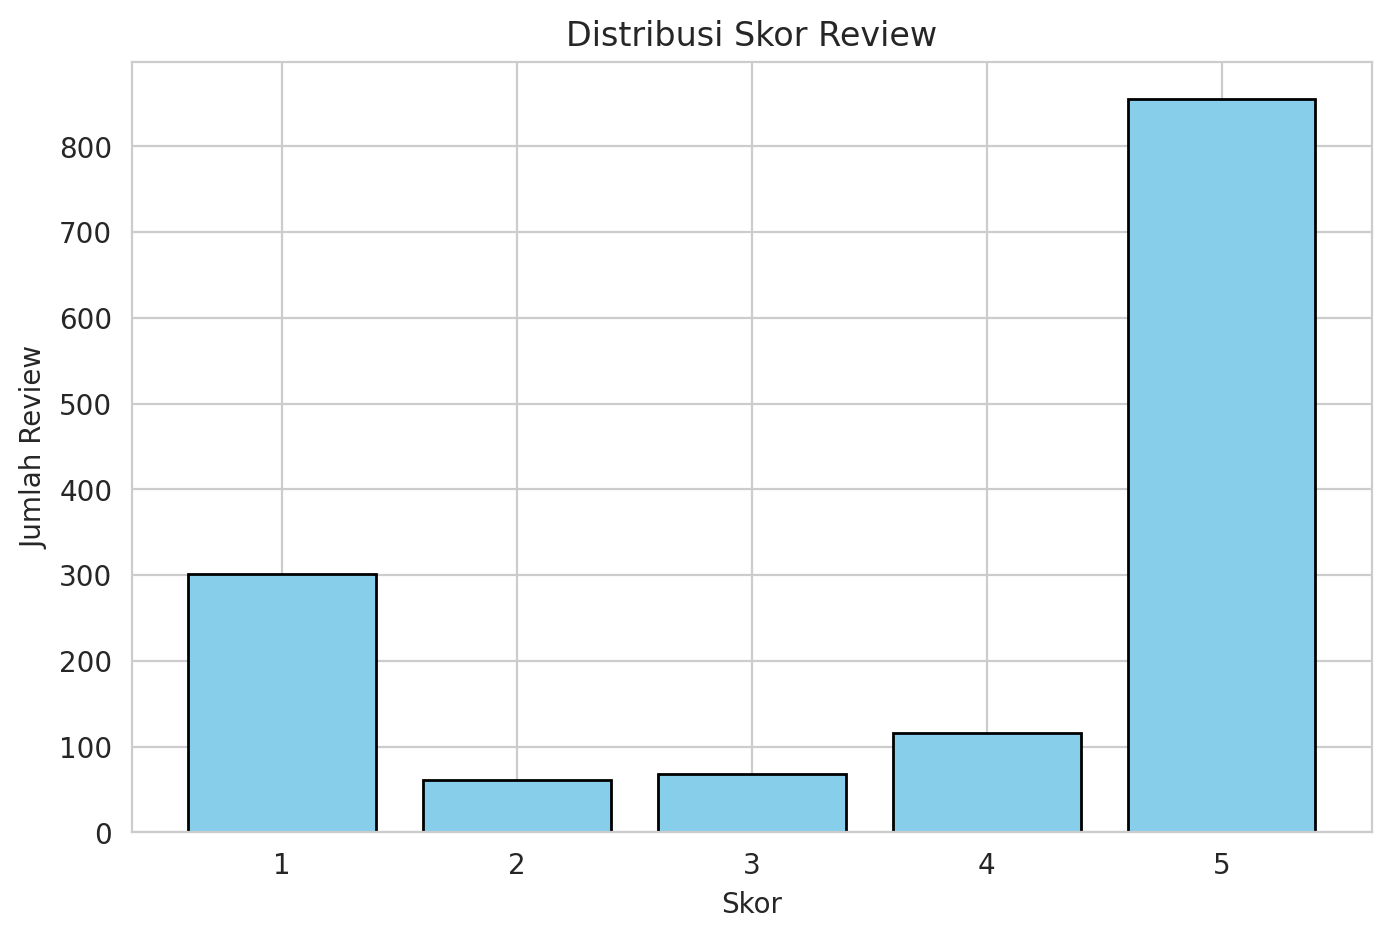

In [5]:
# Cek jumlah skor review
print("\nDistribusi skor review:")
print(df_mymrtjrev['score'].value_counts())
plt.figure(figsize=(8, 5))
plt.hist(df_mymrtjrev['score'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Distribusi Skor Review')
plt.xlabel('Skor')
plt.ylabel('Jumlah Review')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

In [6]:
# Preprocessing Pipeline

# Membuat salinan dataframe untuk proses preprocessing
df_processed = df_mymrtjrev.copy()

# Fungsi untuk membersihkan teks dengan REGEX
def clean_text(text):
    # Convert to string jika bukan string
    text = str(text)

    # 1. Menghapus emoji
    text = emoji.replace_emoji(text, replace='')

    # 2. Menghapus URL
    text = re.sub(r'http\S+|www.\S+', '', text)

    # 3. Menghapus mention (@username)
    text = re.sub(r'@\w+', '', text)

    # 4. Menghapus hashtag
    text = re.sub(r'#\w+', '', text)

    # 5. Menghapus angka
    text = re.sub(r'\d+', '', text)

    # 6. Menghapus karakter berulang seperti "aaa" -> "a"
    text = re.sub(r'(.)\1+', r'\1', text)

    # 7. Menghapus spasi berlebih
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

In [7]:
# 1. Pembersihan teks dengan REGEX
df_processed['content'] = df_processed['content'].swifter.apply(clean_text)

# 2. Lower casing
df_processed['content'] = df_processed['content'].astype(str).apply(lambda x: x.lower())
print("\nLangkah 1/7: Pembersihan teks dengan REGEX dan Lowercasing selesai.")

Pandas Apply:   0%|          | 0/1401 [00:00<?, ?it/s]


Langkah 1/7: Pembersihan teks dengan REGEX dan Lowercasing selesai.


In [8]:
# 3. Expand Contractions: Mengembangkan singkatan umum Bahasa Indonesia
contraction_mapping = {
    "yg": "yang", "udah": "sudah", "ga": "tidak", "gak": "tidak",
    "bgt": "banget", "bgtt": "banget", "jg": "juga", "aja": "saja",
    "bkn": "bukan", "tdk": "tidak", "jd": "jadi", "tp": "tapi",
    "gk": "tidak", "blm": "belum", "sdh": "sudah", "krn": "karena",
    "dgn": "dengan", "utk": "untuk", "sampe": "sampai", "udh": "sudah",
    "dr": "dari", "dlm": "dalam", "bbrp": "beberapa", "bs": "bisa",
    "mrt": "mass rapid transit", "app": "aplikasi", "lg": "lagi",
    "td": "tadi", "ny": "nya", "banget": "sangat", "bangett": "sangat",
    "sm": "sama", "klo": "kalau", "kl": "kalau", "kyk": "seperti",
    "org": "orang", "pdhl": "padahal", "dpt": "dapat", "dg": "dengan",
    "skrg": "sekarang", "sblm": "sebelum", "stlh": "setelah", "utk": "untuk",
    "yb": "yang", "lbh": "lebih", "krn": "karena", "spt": "seperti",
    "tsb": "tersebut", "tll": "terlalu", "sdkt": "sedikit", "gpp": "tidak apa apa",
    "otw": "dalam perjalanan", "pls": "tolong", "thx": "terima kasih"
}

def expand_contractions(text, mapping):
    words = text.split()
    expanded_words = [mapping[word] if word in mapping else word for word in words]
    return ' '.join(expanded_words)

df_processed['content'] = df_processed['content'].apply(lambda x: expand_contractions(x, contraction_mapping))
print("Langkah 2/7: Expand Contractions selesai.")

Langkah 2/7: Expand Contractions selesai.


In [9]:
# 4. Punctuations Removal: Menghapus tanda baca
df_processed['content'] = df_processed['content'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
print("Langkah 3/7: Punctuations Removal selesai.")

Langkah 3/7: Punctuations Removal selesai.


In [10]:
# 5. Tokenization: Memecah teks menjadi kata-kata
df_processed['tokens'] = df_processed['content'].apply(word_tokenize)
print("Langkah 4/7: Tokenization selesai.")
print("Contoh token setelah tokenisasi:", df_processed['tokens'].head(2).tolist())

Langkah 4/7: Tokenization selesai.
Contoh token setelah tokenisasi: [['opsi', 'pembayaran', 'untuk', 'bank', 'tidak', 'lengkap', 'masih', 'di', 'monopoli', 'blu', 'bca'], ['kalau', 'bikin', 'aplikasi', 'yang', 'niat', 'kalo', 'hujan', 'knp', 'harus', 'eror', 'terus', 'tidak', 'bisa', 'dibuka', 'ganti', 'pihak', 'ketiga', 'rombak', 'tim', 'it', 'ini', 'jakarta', 'bukan', 'kota', 'kecil', 'masih', 'banyak', 'tenaga', 'it', 'yang', 'mumpuni', 'memalukan']]


In [11]:
# 6. Stopword Removal: Menghapus kata-kata tidak penting (stopword)
factory_stopword = StopWordRemoverFactory()
sastrawi_stopwords = factory_stopword.get_stop_words()
indonesian_stopwords_nltk = stopwords.words('indonesian')
english_stopwords = stopwords.words('english')

custom_stopwords = [
    'yg', 'bs', 'tyt', 'aja', 'loh', 'deh', 'dong', 'sih', 'nya', 'nih', 'udah',
    'bgt', 'banget', 'gak', 'ga', 'gk', 'jg', 'mrtj', 'mrt', 'aplikasi', 'review',
    'halo', 'admin', 'kak', 'min', 'hi', 'hai', 'terima', 'kasih', 'bantu', 'ya',
    'wah', 'waduh', 'lho', 'oh', 'oke', 'ok', 'silahkan', 'please', 'tolong', 'help',
    'aplikasinya', 'nya', 'dong', 'sih', 'deh', 'lah', 'kok', 'tau', 'dong'
]

all_stopwords = set(sastrawi_stopwords + indonesian_stopwords_nltk + english_stopwords + custom_stopwords)

df_processed['tokens_no_stopwords'] = df_processed['tokens'].apply(
    lambda x: [word for word in x if word not in all_stopwords and len(word) > 1 and not word.isdigit()]
)
print("Langkah 5/7: Stopword Removal (Indonesia, Inggris, dan kustom) selesai.")
print("Contoh token setelah stopword removal:", df_processed['tokens_no_stopwords'].head(2).tolist())

Langkah 5/7: Stopword Removal (Indonesia, Inggris, dan kustom) selesai.
Contoh token setelah stopword removal: [['opsi', 'pembayaran', 'bank', 'lengkap', 'monopoli', 'blu', 'bca'], ['bikin', 'niat', 'kalo', 'hujan', 'knp', 'eror', 'dibuka', 'ganti', 'ketiga', 'rombak', 'tim', 'jakarta', 'kota', 'tenaga', 'mumpuni', 'memalukan']]


In [12]:
# 7. Stemming: Mengubah kata menjadi bentuk dasar menggunakan Sastrawi
factory_stemmer = StemmerFactory()
sastrawi_stemmer = factory_stemmer.create_stemmer()

def sastrawi_stem(word_list):
    return [sastrawi_stemmer.stem(word) for word in word_list]

df_processed['tokens_stemmed'] = df_processed['tokens_no_stopwords'].swifter.apply(sastrawi_stem)
print("Langkah 6/7: Stemming (menggunakan Sastrawi) selesai.")
print("Contoh token setelah stemming:", df_processed['tokens_stemmed'].head(2).tolist())

Pandas Apply:   0%|          | 0/1401 [00:00<?, ?it/s]

Langkah 6/7: Stemming (menggunakan Sastrawi) selesai.
Contoh token setelah stemming: [['opsi', 'bayar', 'bank', 'lengkap', 'monopoli', 'blu', 'bca'], ['bikin', 'niat', 'kalo', 'hujan', 'knp', 'eror', 'buka', 'ganti', 'tiga', 'rombak', 'tim', 'jakarta', 'kota', 'tenaga', 'mumpuni', 'malu']]


In [13]:
# Menggabungkan kembali token menjadi teks bersih final
df_processed['clean_text_final'] = df_processed['tokens_stemmed'].apply(lambda x: ' '.join(x))



In [14]:
# Rare Words Removal
all_words_clean = ' '.join(df_processed['clean_text_final']).split()
fdist_clean = FreqDist(all_words_clean)

# Hitung threshold berdasarkan persentil ke-5
rare_words_threshold = max(2, int(np.percentile(list(fdist_clean.values()), 5)))
rare_words = set(word for word, count in fdist_clean.items() if count < rare_words_threshold)

def remove_rare_words(text_list, rare_words_set):
    return [word for word in text_list if word not in rare_words_set]

df_processed['tokens_final_filtered'] = df_processed['tokens_stemmed'].apply(
    lambda x: remove_rare_words(x, rare_words)
)
df_processed['clean_text_final'] = df_processed['tokens_final_filtered'].apply(lambda x: ' '.join(x))
print("Langkah 7/7: Penghapusan kata-kata jarang selesai.")

Langkah 7/7: Penghapusan kata-kata jarang selesai.


In [15]:
# Hitung sentimen sebelum menyimpan data bersih
# Fungsi untuk menerjemahkan sentimen bahasa Indonesia (opsional)
def indonesian_sentiment(text):
    positive_words = ['bagus', 'baik', 'mantap', 'cepat', 'mudah', 'senang', 'puas', 'recommended', 'keren', 'helpful']
    negative_words = ['jelek', 'buruk', 'lambat', 'sulit', 'kecewa', 'error', 'bug', 'crash', 'lemot', 'gagal']

    text_lower = text.lower()
    positive_count = sum(1 for word in positive_words if word in text_lower)
    negative_count = sum(1 for word in negative_words if word in text_lower)

    if positive_count > negative_count:
        return 1
    elif negative_count > positive_count:
        return -1
    else:
        return 0

# Menambahkan beberapa kolom sentimen
df_processed['sentiment_polarity'] = df_processed['content'].apply(lambda x: TextBlob(x).polarity)
df_processed['sentiment_subjective'] = df_processed['content'].apply(lambda x: TextBlob(x).subjectivity)
df_processed['sentiment_rating'] = df_processed['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3 else 'Negative'))
df_processed['indonesian_sentiment'] = df_processed['content'].apply(indonesian_sentiment)

In [16]:
# Simpan Data Bersih ke CSV dan Excel
df_processed_final = df_processed.loc[:, ["content", "score", "sentiment_polarity", "sentiment_subjective",
                                          "sentiment_rating", "indonesian_sentiment", "clean_text_final"]]
df_processed_final.to_csv('cleandata.csv', index=False)
df_processed_final.to_excel('cleandata.xlsx', index=False)
print("\nData bersih berhasil disimpan ke cleandata.csv dan cleandata.xlsx")

print("\nSampel data setelah preprocessing:")
print(df_processed_final.head())


Data bersih berhasil disimpan ke cleandata.csv dan cleandata.xlsx

Sampel data setelah preprocessing:
                                             content  score  \
0  opsi pembayaran untuk bank tidak lengkap masih...      1   
1  kalau bikin aplikasi yang niat kalo hujan knp ...      1   
2  ke balik milih setasiun buat masuk sudah nyamp...      1   
3                        tidak bisa bayar pakai qris      1   
4  suka dari segi pembayaran masih dipermudah sep...      5   

   sentiment_polarity  sentiment_subjective sentiment_rating  \
0                 0.0              0.000000         Negative   
1                 0.0              0.000000         Negative   
2                 0.0              0.000000         Negative   
3                 0.0              0.000000         Negative   
4                 0.0              0.357143         Positive   

   indonesian_sentiment                                   clean_text_final  
0                     0           opsi bayar bank lengka

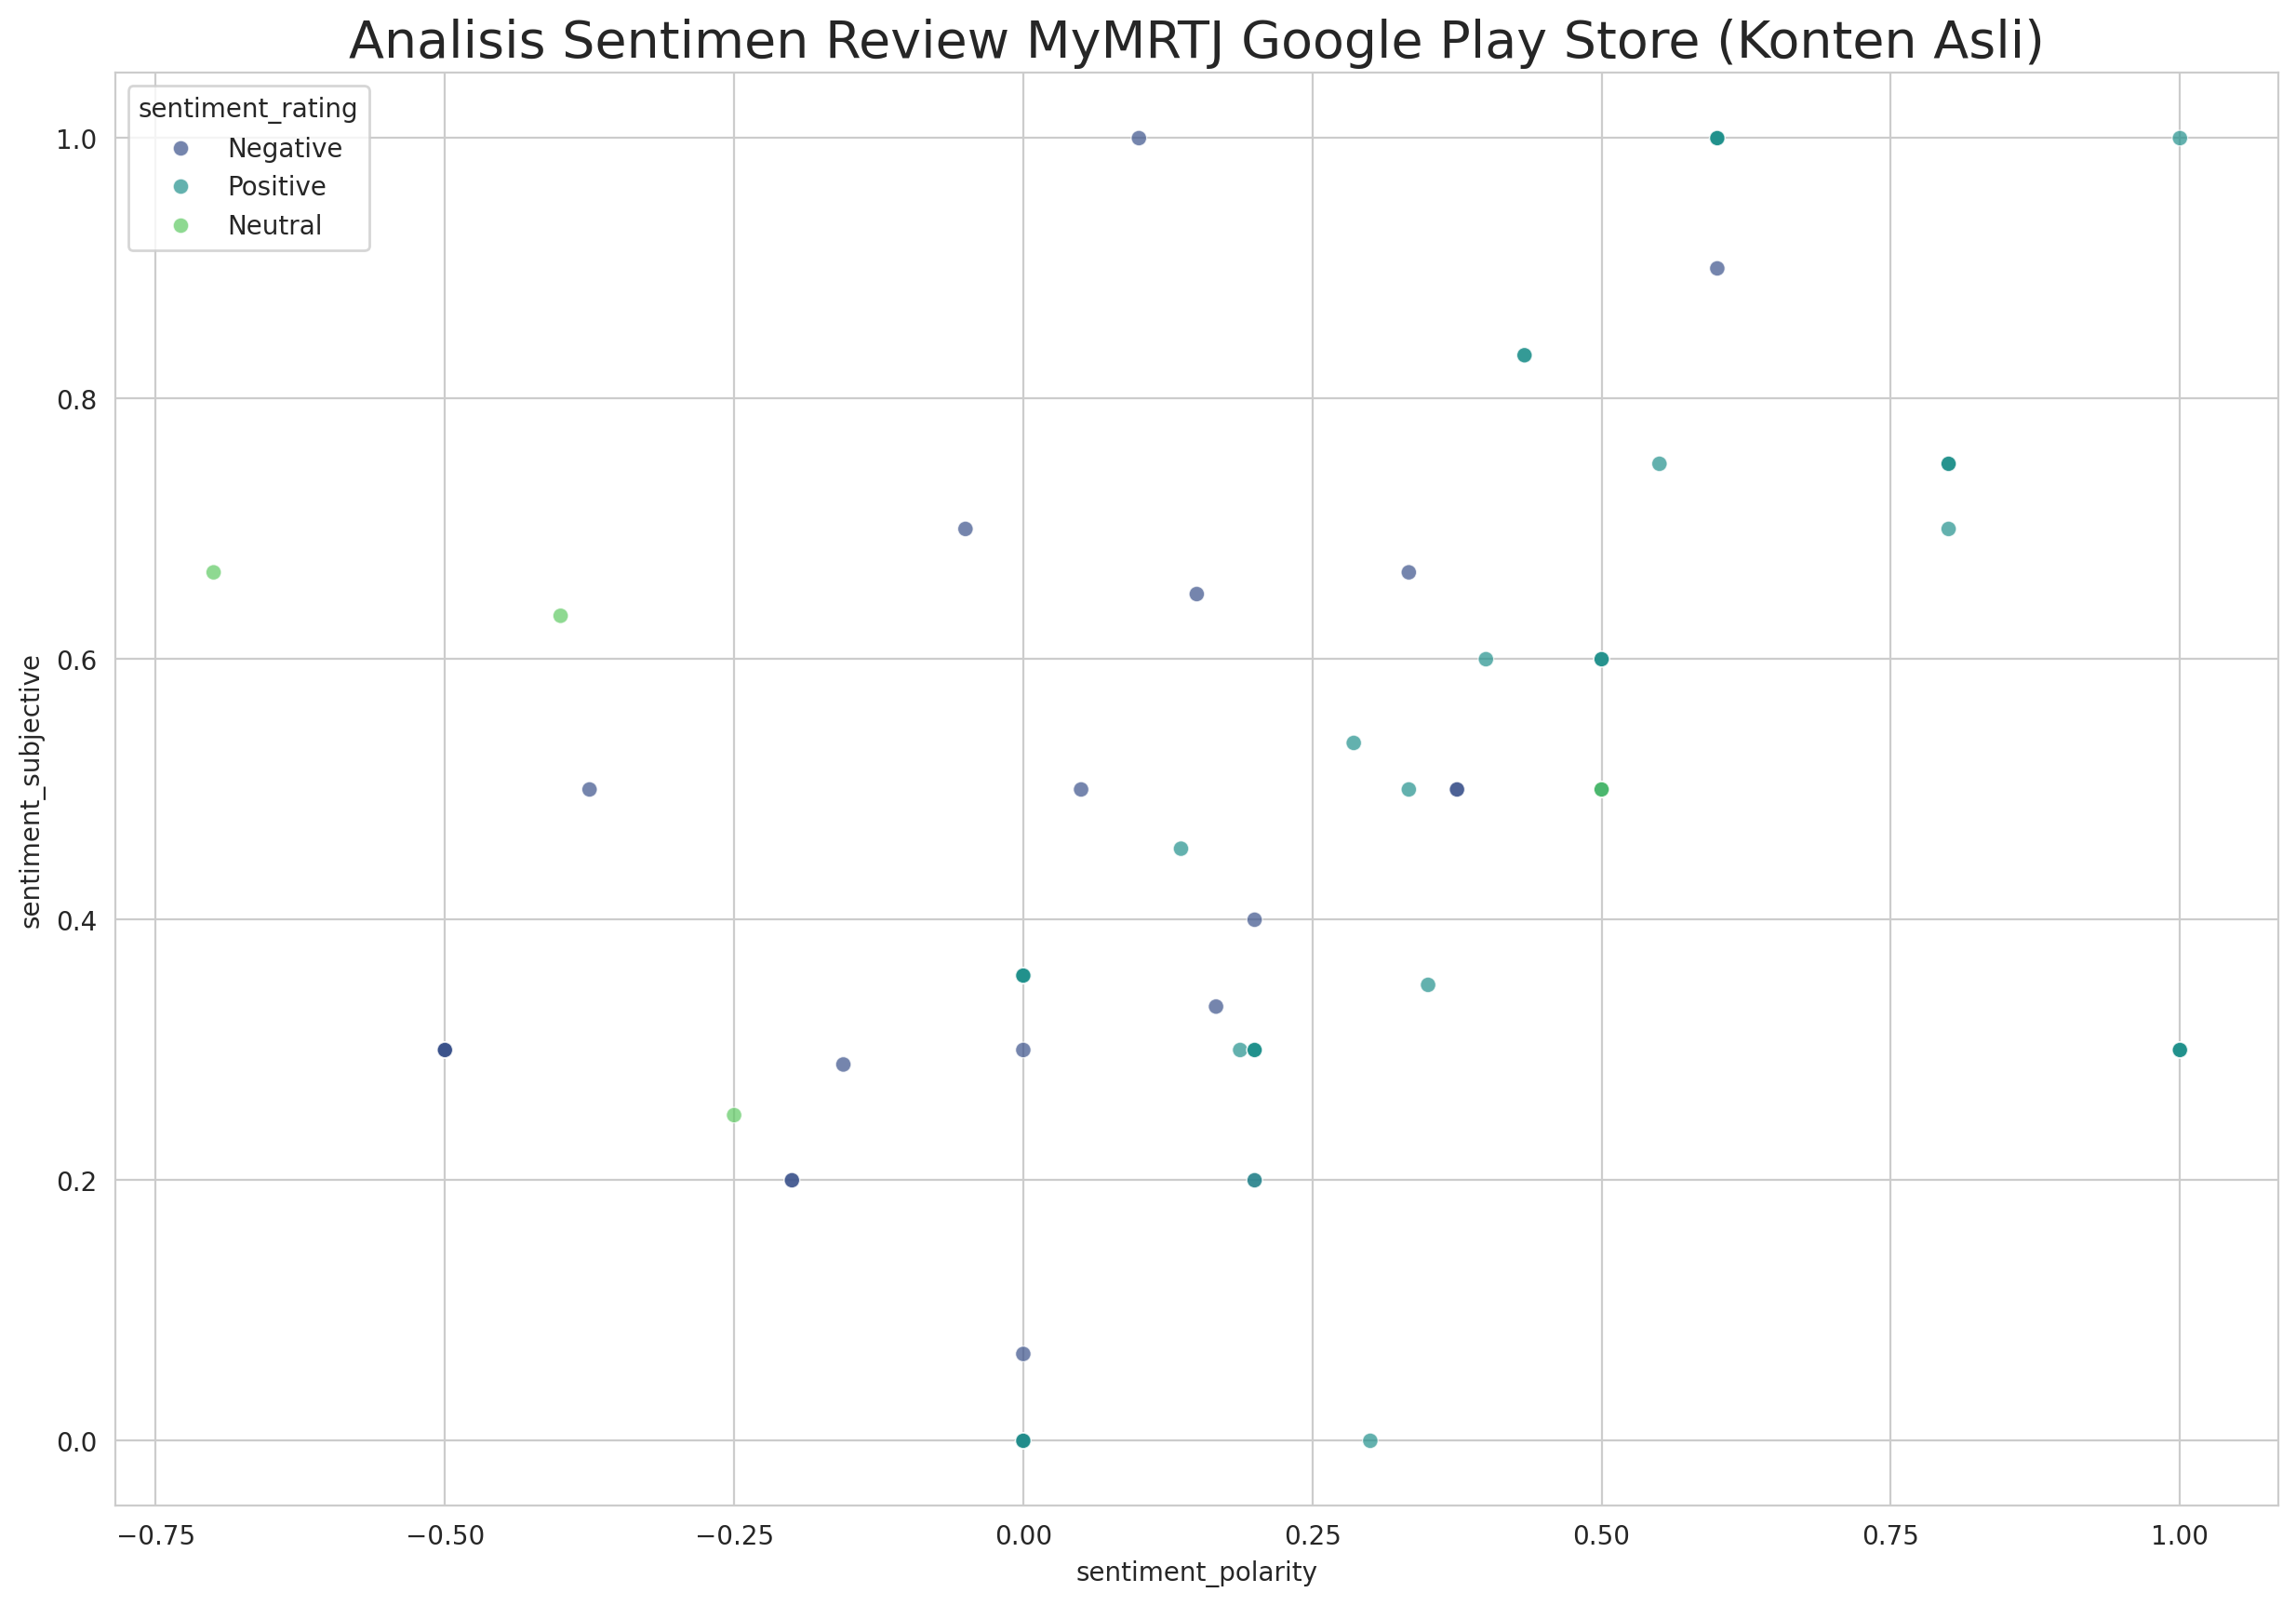

In [17]:
# Analisis Sentimen Awal (pada konten asli)
plt.figure(figsize=(15, 10))
sns.scatterplot(x=df_processed_final['sentiment_polarity'], y=df_processed_final['sentiment_subjective'],
                hue=df_processed_final['sentiment_rating'], edgecolor='white', palette="viridis", alpha=0.7)
plt.title("Analisis Sentimen Review MyMRTJ Google Play Store (Konten Asli)", fontsize=20)
plt.show()

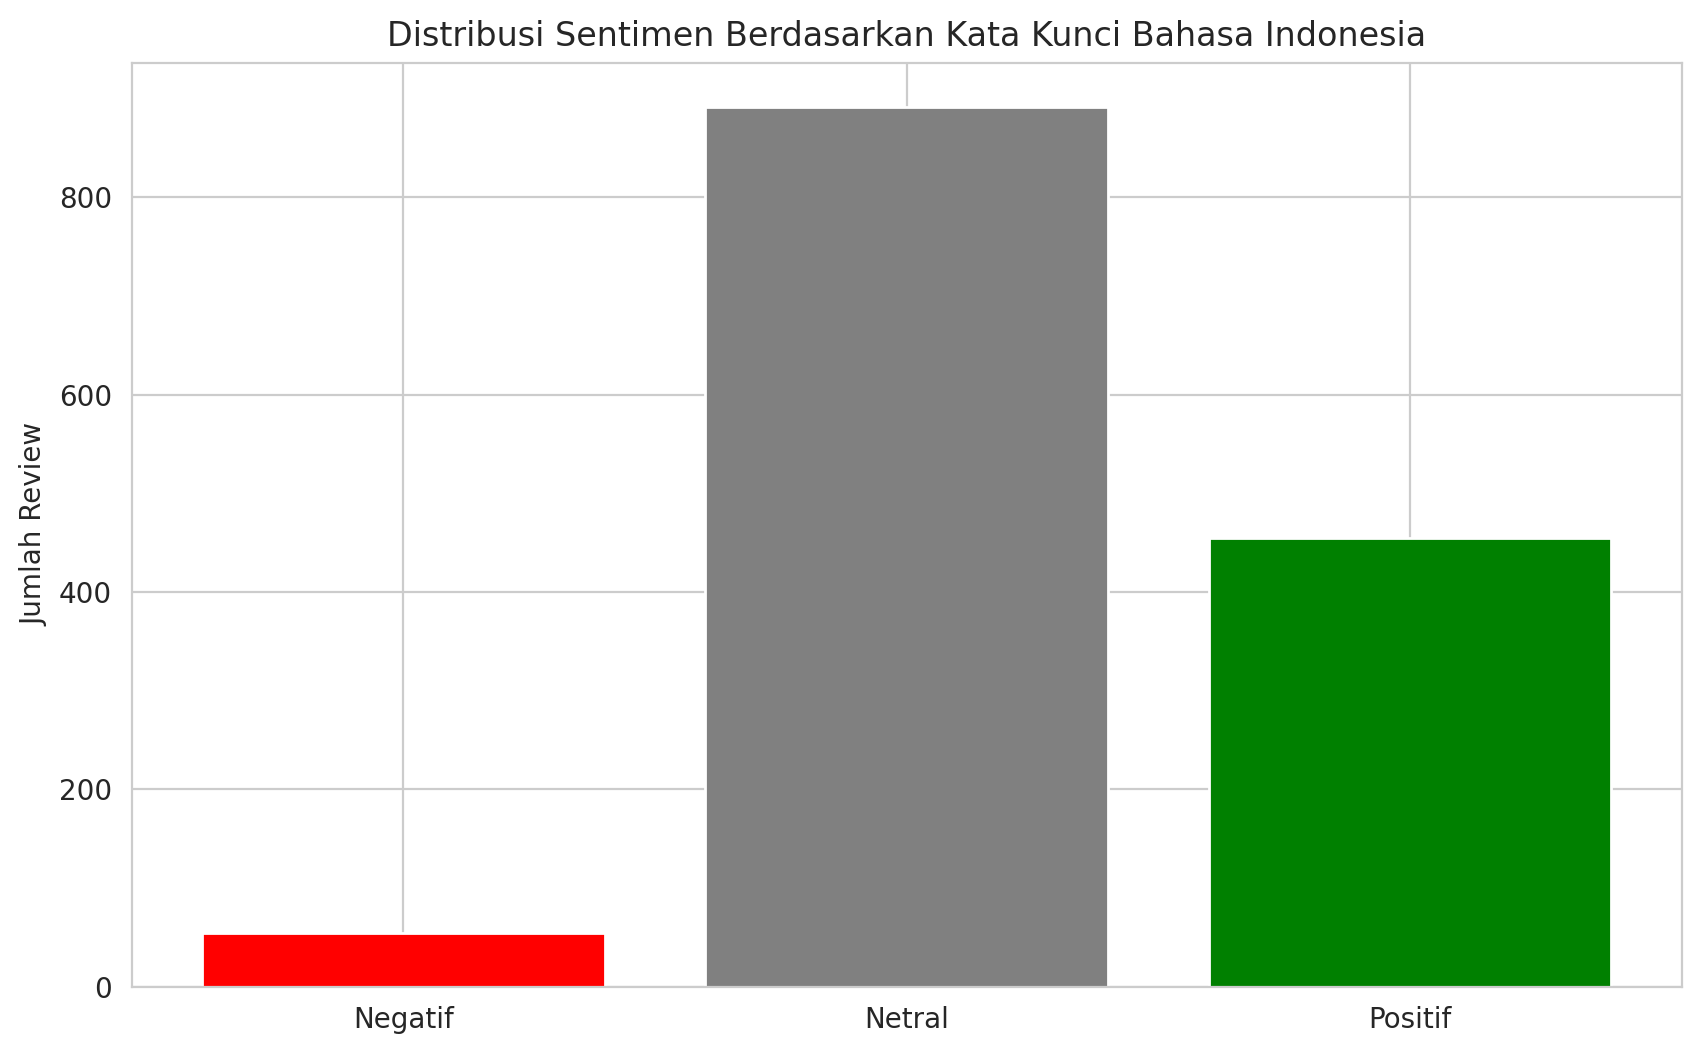

In [18]:
# Analisis dengan sentimen bahasa Indonesia
plt.figure(figsize=(10, 6))
sentiment_counts = df_processed_final['indonesian_sentiment'].value_counts()
plt.bar(['Negatif', 'Netral', 'Positif'],
        [sentiment_counts.get(-1, 0), sentiment_counts.get(0, 0), sentiment_counts.get(1, 0)],
        color=['red', 'gray', 'green'])
plt.title('Distribusi Sentimen Berdasarkan Kata Kunci Bahasa Indonesia')
plt.ylabel('Jumlah Review')
plt.show()


Analisis Kata Sering Muncul dari Teks yang Sudah Bersih


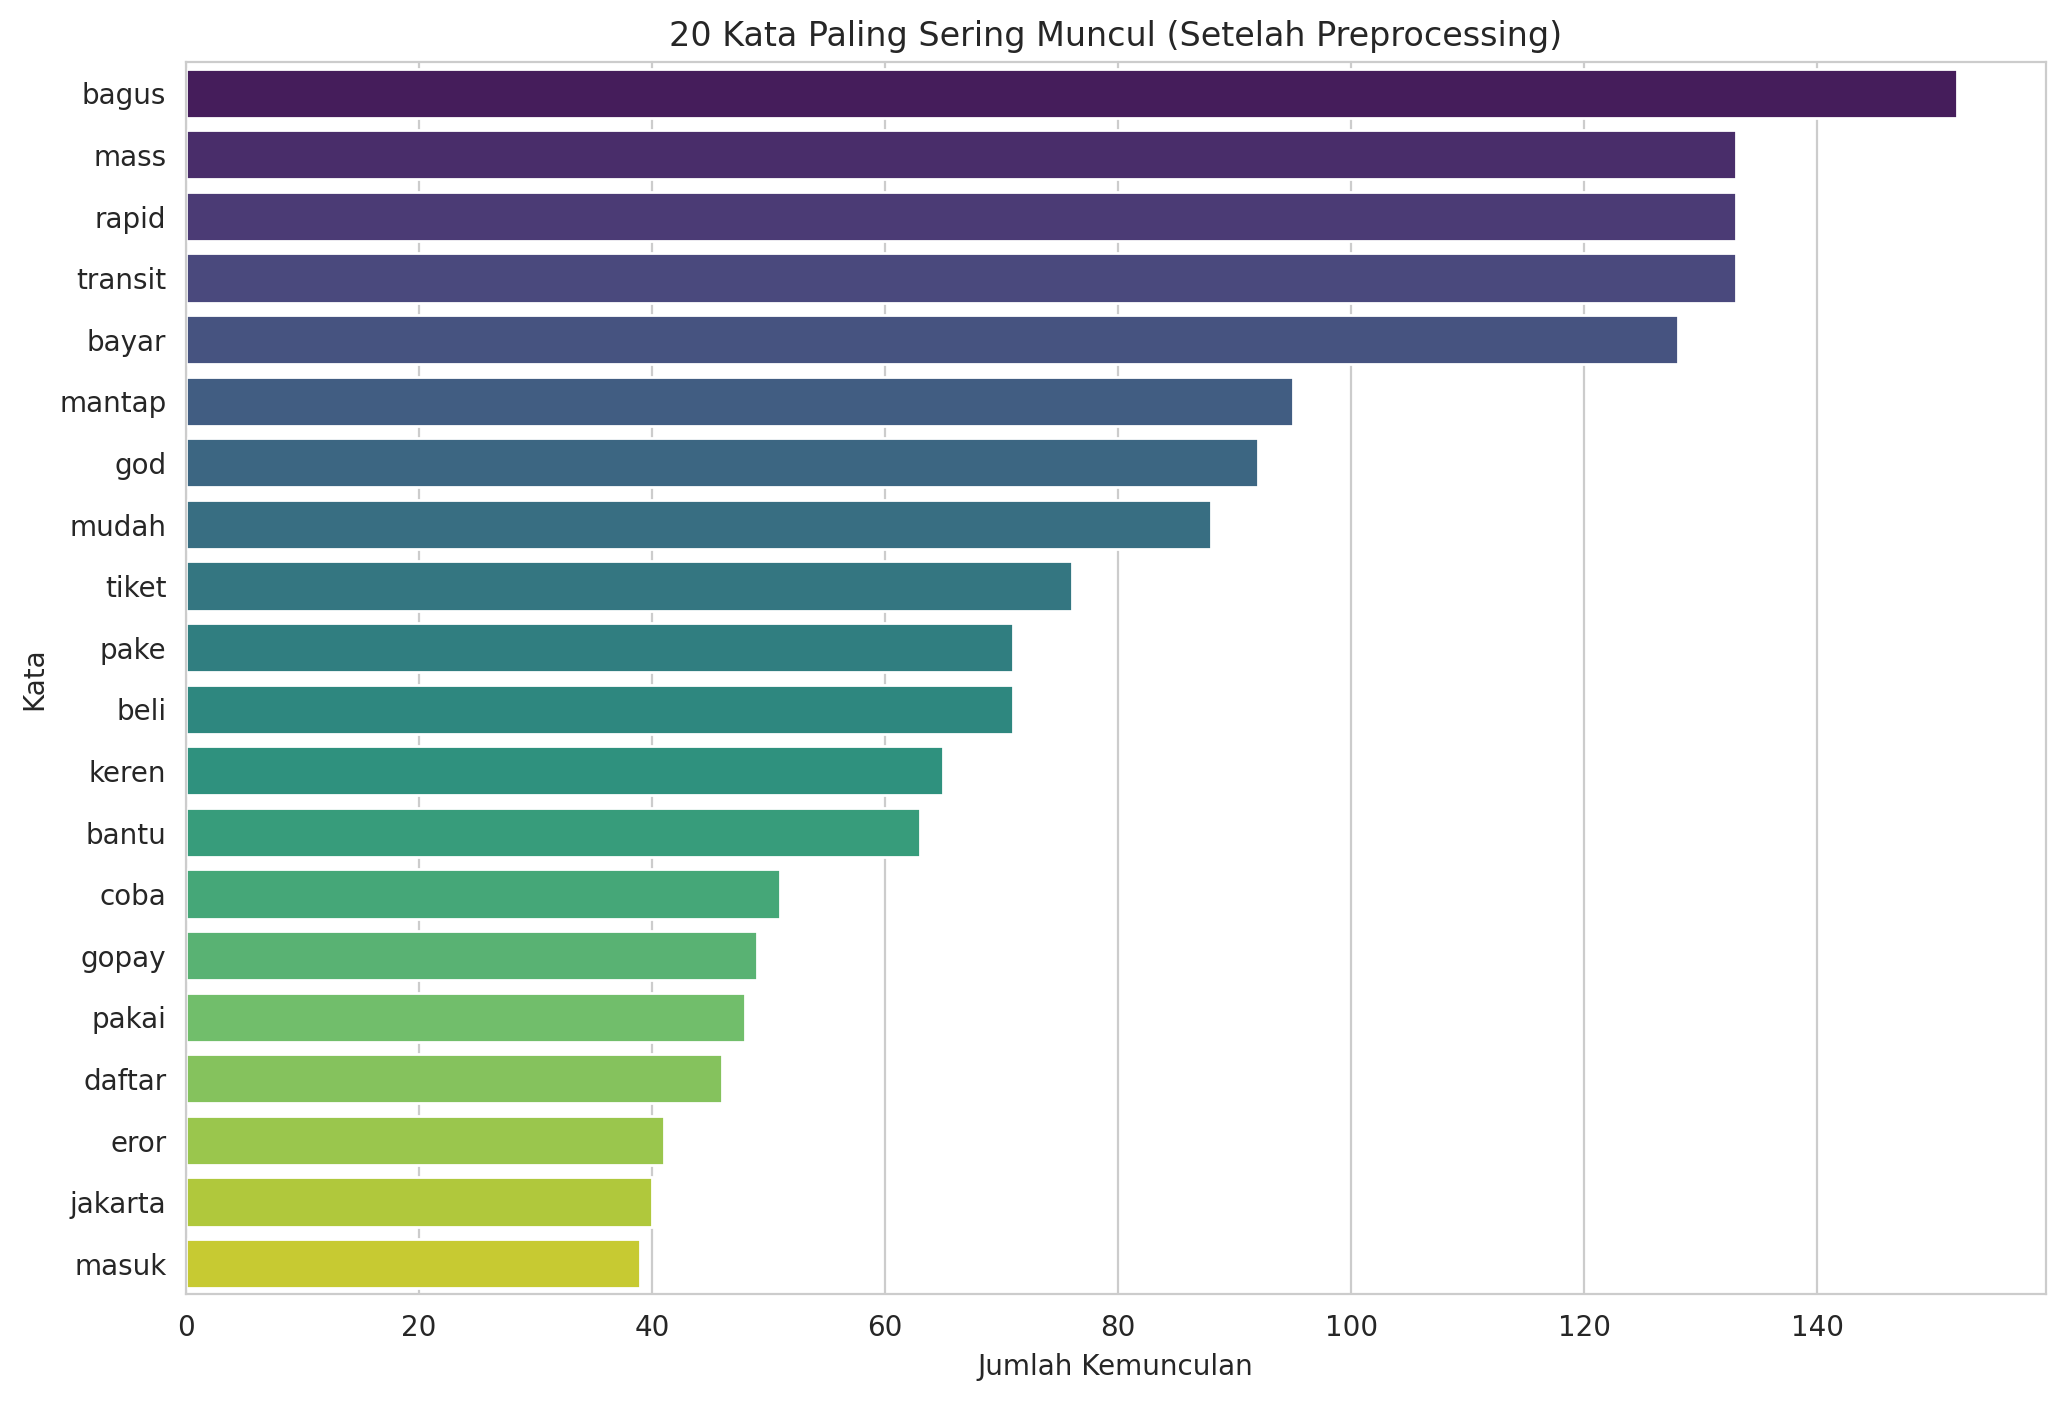

In [19]:
# Analisis Kata Sering Muncul (Frequent Words) dari Teks Bersih
print("\nAnalisis Kata Sering Muncul dari Teks yang Sudah Bersih")
all_words_final_processed = ' '.join(df_processed_final['clean_text_final']).split()
fdist_final_processed = FreqDist(all_words_final_processed)
words_df_final_processed = pd.DataFrame({'word':list(fdist_final_processed.keys()), 'count':list(fdist_final_processed.values())})

# Visualisasi kata paling sering muncul
top_words = words_df_final_processed.nlargest(columns="count", n=20)
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='word', data=top_words, palette='viridis')
plt.title('20 Kata Paling Sering Muncul (Setelah Preprocessing)')
plt.xlabel('Jumlah Kemunculan')
plt.ylabel('Kata')
plt.show()

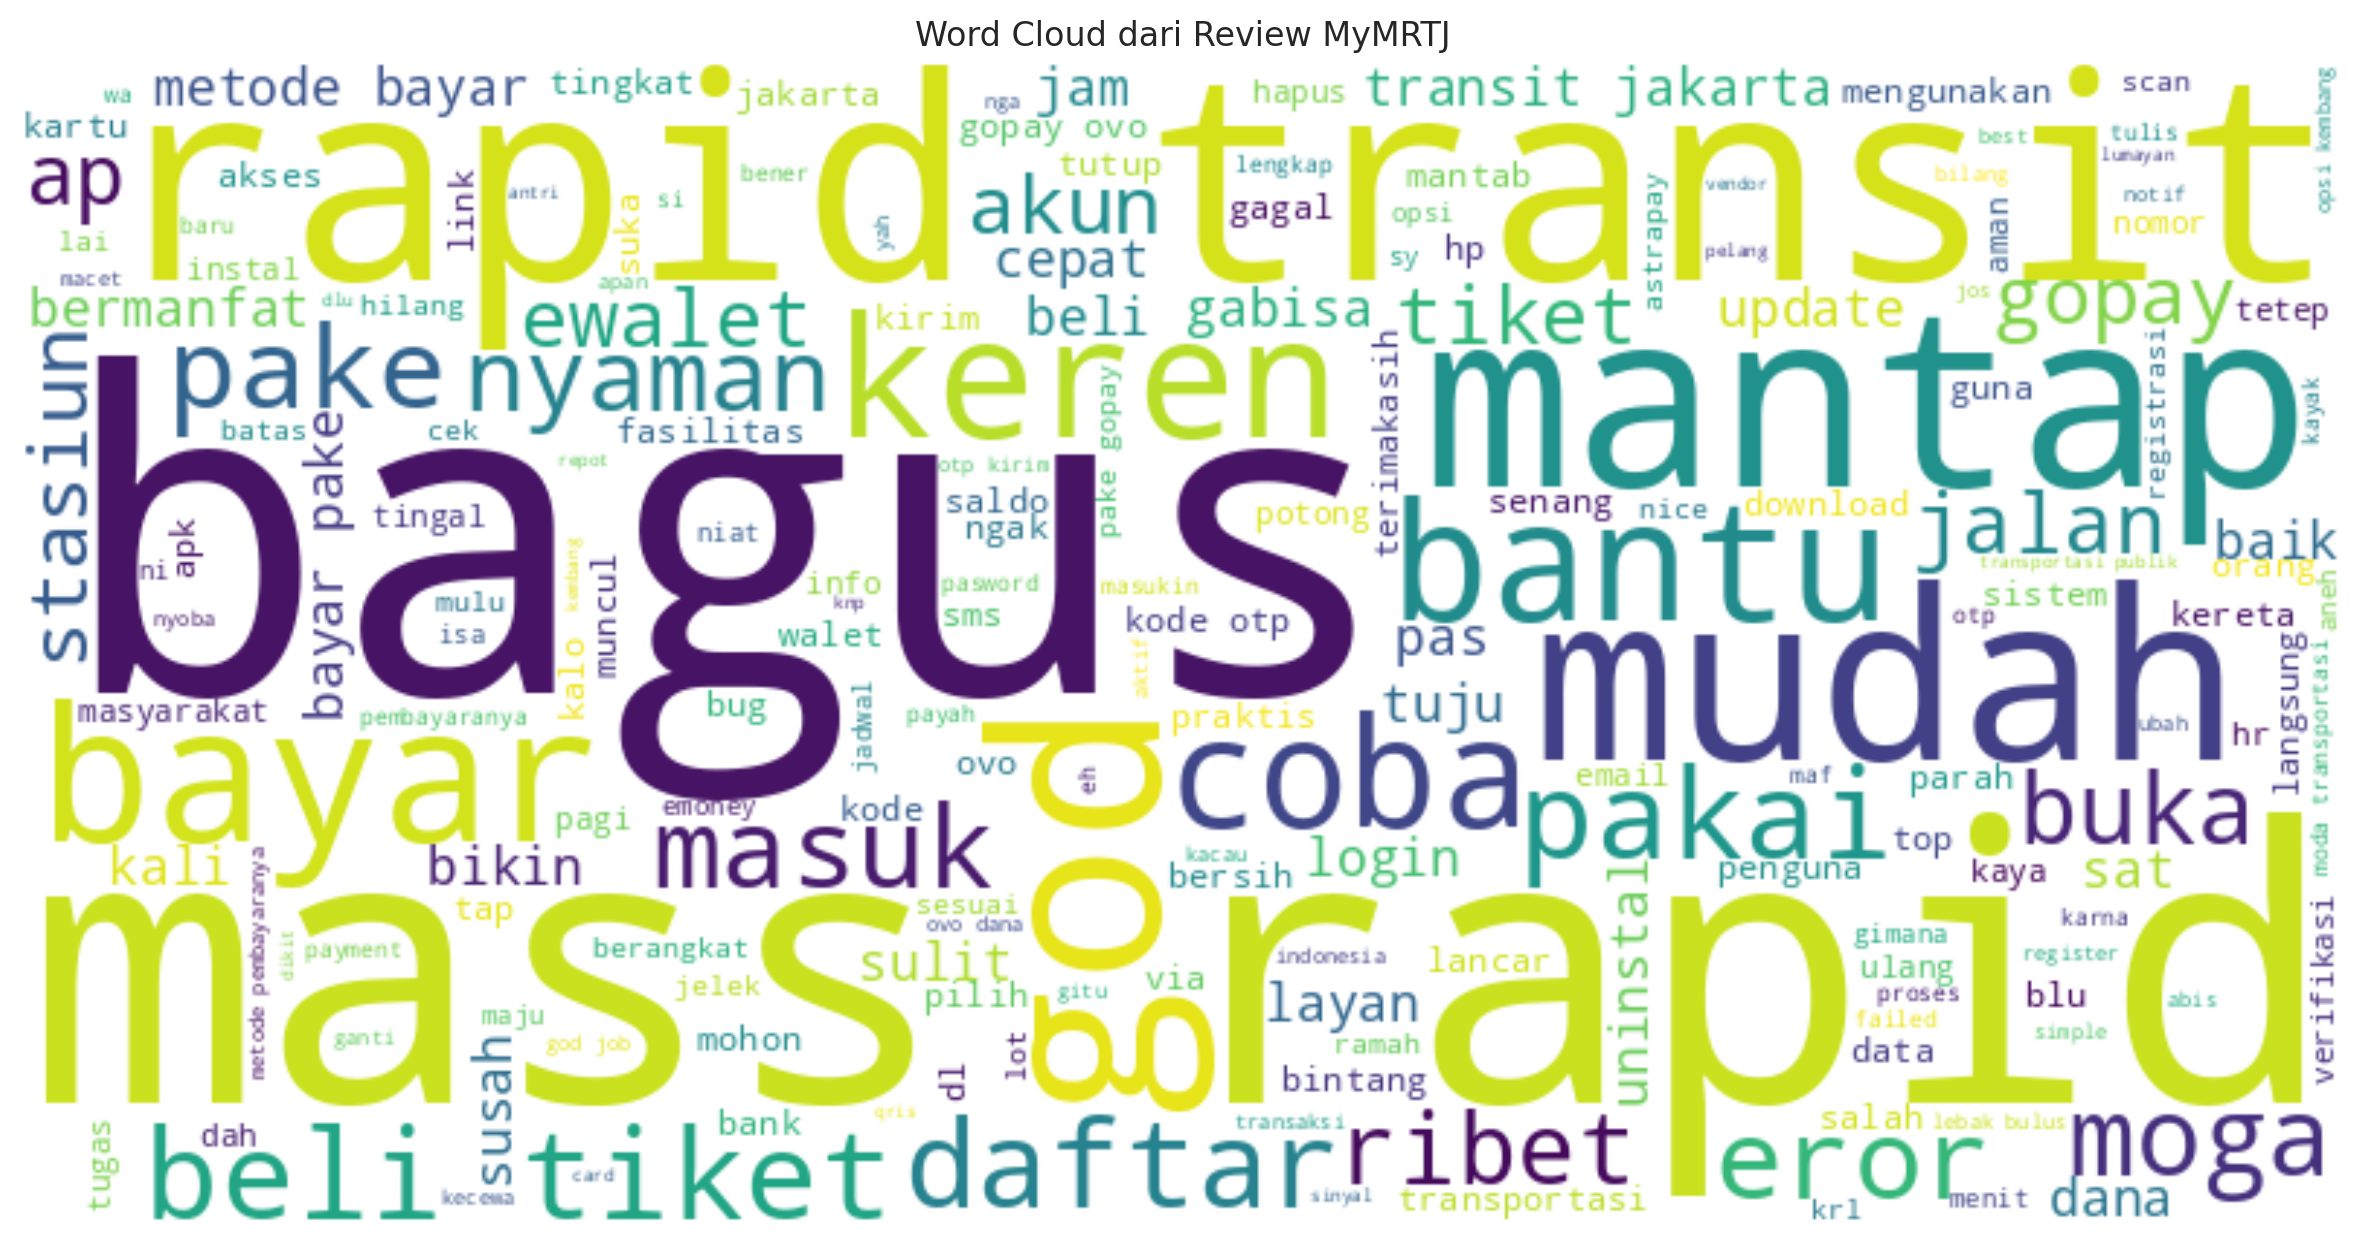

In [20]:
# Word Cloud
try:
    from wordcloud import WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_processed_final['clean_text_final']))
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud dari Review MyMRTJ')
    plt.show()
except:
    print("Install wordcloud dengan: !pip install wordcloud")

In [21]:
# LANGKAH SELANJUTNYA: ANALISIS BAG OF WORDS (BoW) DAN KLASIFIKASI
print("MEMULAI ANALISIS BAG OF WORDS (BoW) DAN KLASIFIKASI SENTIMEN")

# 1. Menyiapkan Data untuk Pemodelan
X = df_processed_final['clean_text_final']
y = df_processed_final['sentiment_rating']

# Cek distribusi target sentimen
print("\nDistribusi kategori sentimen:")
print(y.value_counts())

MEMULAI ANALISIS BAG OF WORDS (BoW) DAN KLASIFIKASI SENTIMEN

Distribusi kategori sentimen:
sentiment_rating
Positive    971
Negative    362
Neutral      68
Name: count, dtype: int64


In [22]:
# 2. Pembagian Data (Training-Test Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nJumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")


Jumlah data training: 1120
Jumlah data testing: 281


In [23]:
# 3. Ekstraksi Fitur menggunakan Bag of Words (CountVectorizer) dan TF-IDF
vectorizer_bow = CountVectorizer(max_features=5000, ngram_range=(1,2))
vectorizer_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

print(f"\nDimensi fitur BoW (training): {X_train_bow.shape}")
print(f"Dimensi fitur TF-IDF (training): {X_train_tfidf.shape}")


Dimensi fitur BoW (training): (1120, 2871)
Dimensi fitur TF-IDF (training): (1120, 2871)


In [24]:
# 4. Pemodelan Klasifikasi Sentimen dengan berbagai algoritma
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Multinomial NB': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nMelatih model {name}...")

    # Gunakan data BoW
    model.fit(X_train_bow, y_train)
    y_pred_bow = model.predict(X_test_bow)
    accuracy_bow = accuracy_score(y_test, y_pred_bow)

    # Gunakan data TF-IDF
    model.fit(X_train_tfidf, y_train)
    y_pred_tfidf = model.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

    results[name] = {
        'BoW': accuracy_bow,
        'TF-IDF': accuracy_tfidf
    }

    print(f"{name} - Akurasi BoW: {accuracy_bow:.4f}, Akurasi TF-IDF: {accuracy_tfidf:.4f}")


Melatih model Logistic Regression...
Logistic Regression - Akurasi BoW: 0.8363, Akurasi TF-IDF: 0.8505

Melatih model Multinomial NB...
Multinomial NB - Akurasi BoW: 0.8683, Akurasi TF-IDF: 0.8434

Melatih model SVM...
SVM - Akurasi BoW: 0.8256, Akurasi TF-IDF: 0.8470

Melatih model Random Forest...
Random Forest - Akurasi BoW: 0.8114, Akurasi TF-IDF: 0.8256


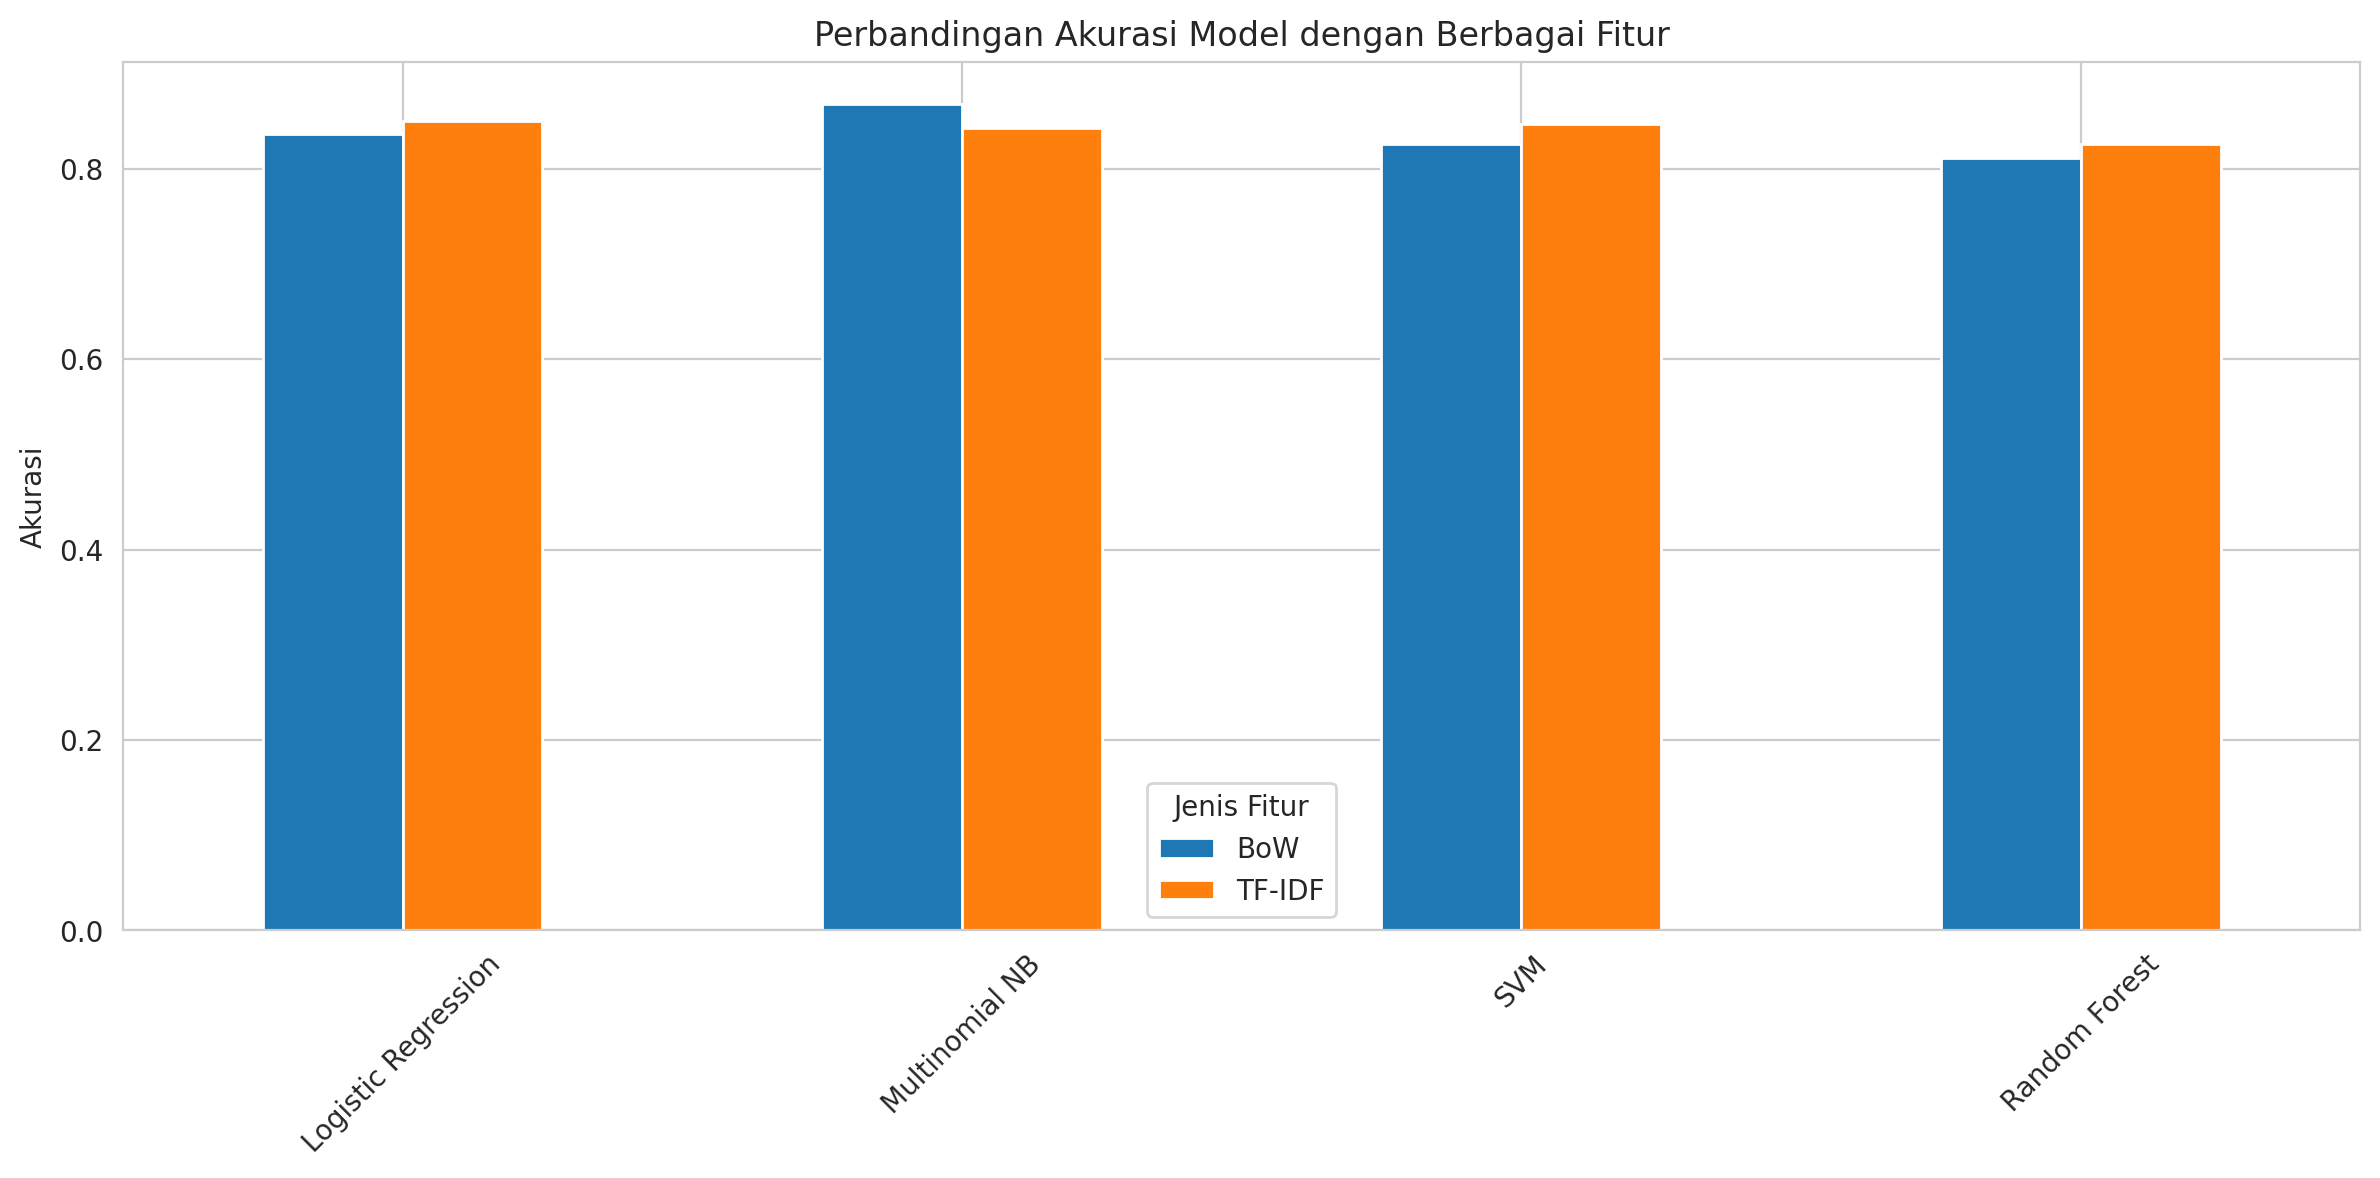

In [25]:
# Visualisasi perbandingan akurasi
results_df = pd.DataFrame(results).T
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Perbandingan Akurasi Model dengan Berbagai Fitur')
plt.ylabel('Akurasi')
plt.xticks(rotation=45)
plt.legend(title='Jenis Fitur')
plt.tight_layout()
plt.show()

In [26]:
# Pilih model terbaik
best_model_name = max(results, key=lambda x: max(results[x].values()))
best_model_accuracy = max(results[best_model_name].values())
best_feature_type = 'BoW' if results[best_model_name]['BoW'] > results[best_model_name]['TF-IDF'] else 'TF-IDF'

print(f"\nModel terbaik: {best_model_name} dengan {best_feature_type} (Akurasi: {best_model_accuracy:.4f})")

# Latih ulang model terbaik dengan semua data training
if best_feature_type == 'BoW':
    X_train_final = X_train_bow
    X_test_final = X_test_bow
    vectorizer = vectorizer_bow
else:
    X_train_final = X_train_tfidf
    X_test_final = X_test_tfidf
    vectorizer = vectorizer_tfidf

best_model = models[best_model_name]
best_model.fit(X_train_final, y_train)
y_pred_final = best_model.predict(X_test_final)

print("\n--- Laporan Klasifikasi Model Terbaik ---")
print(classification_report(y_test, y_pred_final))


Model terbaik: Multinomial NB dengan BoW (Akurasi: 0.8683)

--- Laporan Klasifikasi Model Terbaik ---
              precision    recall  f1-score   support

    Negative       0.80      0.82      0.81        72
     Neutral       0.00      0.00      0.00        14
    Positive       0.89      0.95      0.92       195

    accuracy                           0.87       281
   macro avg       0.56      0.59      0.58       281
weighted avg       0.82      0.87      0.85       281



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


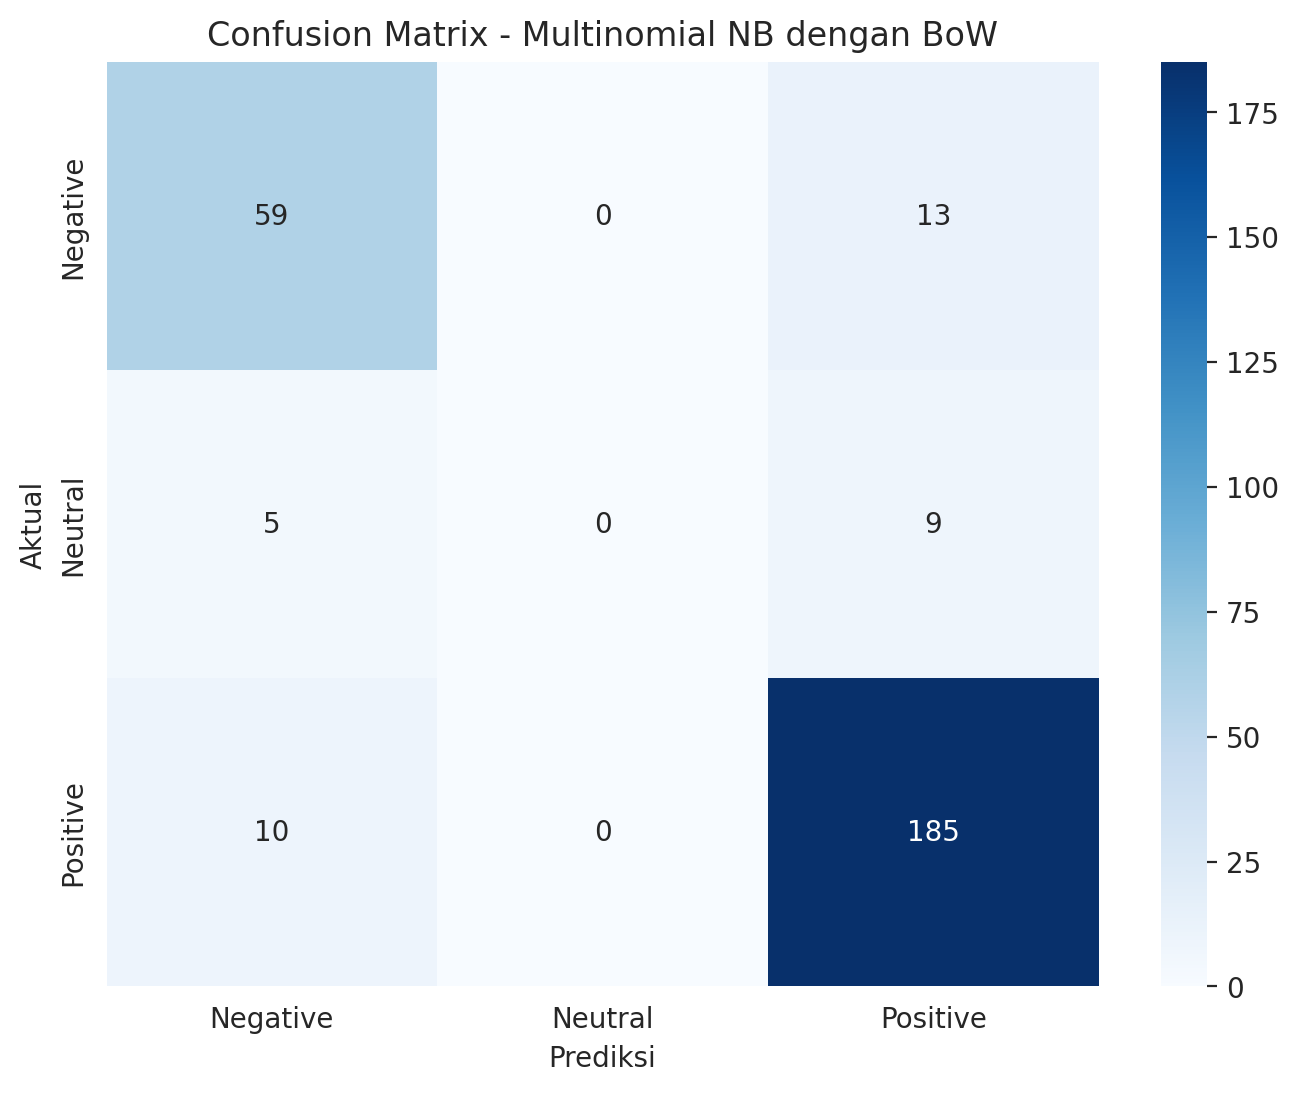

In [27]:
# Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title(f'Confusion Matrix - {best_model_name} dengan {best_feature_type}')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

In [28]:
# 5. Menjelajahi Kata-kata Penting untuk Setiap Sentimen
print("\nKata-kata Penting untuk Setiap Sentimen")
if hasattr(best_model, 'coef_'):
    feature_names = vectorizer.get_feature_names_out()

    for i, class_label in enumerate(best_model.classes_):
        print(f"\nKata-kata Paling Penting untuk Sentimen '{class_label}':")

        if len(best_model.classes_) > 2:
            # Untuk klasifikasi multi-kelas
            coefs = best_model.coef_[i]
        else:
            # Untuk klasifikasi biner
            coefs = best_model.coef_[0] * (1 if i == 1 else -1)

        # Urutkan koefisien
        sorted_indices = np.argsort(coefs)

        top_n = 10
        top_positive_words = [feature_names[j] for j in sorted_indices[-top_n:][::-1]]
        top_negative_words = [feature_names[j] for j in sorted_indices[:top_n]]

        print(f"  Paling berkorelasi positif: {', '.join(top_positive_words)}")
        print(f"  Paling berkorelasi negatif: {', '.join(top_negative_words)}")

print("ANALISIS BAG OF WORDS (BoW) DAN KLASIFIKASI SENTIMEN SELESAI")


Kata-kata Penting untuk Setiap Sentimen
ANALISIS BAG OF WORDS (BoW) DAN KLASIFIKASI SENTIMEN SELESAI
